In [60]:
import sys
import os

# Add the project root directory to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from omegaconf import OmegaConf
from data.dataloader import build_dataloaders
from utils.augmentation import CutMixup, IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD



data_cfg = OmegaConf.load(os.path.join("configs", "data", "imagenet1k.yaml"))
train_cfg = OmegaConf.load(os.path.join("configs", "training", "default.yaml"))
model_cfg = OmegaConf.load(os.path.join("configs", "model", "base.yaml"))
augmentation_cfg = OmegaConf.load(os.path.join("configs", "augmentation", "default.yaml"))


merged_cfg = OmegaConf.create({
    "data": data_cfg,
    "training": train_cfg,
    "model": model_cfg,
    "augmentation": augmentation_cfg,
})

# change batch size to 4
merged_cfg.training.batch_size = 4
print(OmegaConf.to_yaml(merged_cfg))

train_loader, val_loader = build_dataloaders(merged_cfg)



data:
  dataset_name: imagenet1k
  path: /mnt/Auxiliary/datasets/imagenet
  num_classes: 1000
  training_size: 1281167
  validation_size: 50000
training:
  epochs: 300
  devices: auto
  precision: bf16-mixed
  grad_clip: 3.0
  batch_size: 4
  num_workers: 12
  strategy: auto
  gradient_accumulation: 8
  log_interval: 50
  val_interval: 1
  save_interval: 10
  jitter_noise: 0.0
  capacity_loss_weight: 10.0
  ema:
    enabled: false
    decay: 0.9999
    start_epoch: 0
    update_interval: 10
  logging:
    flops: true
    interval: 10
  checkpoints:
    path: path/to/checkpoints
    resume_from_checkpoint: null
model:
  name: nested-vit-base
  embed_dim: 768
  depth: 12
  num_heads: 12
  mlp_ratio: 4
  qkv_bias: true
  patch_size: 16
  img_size: 224
  num_classes: ${data.num_classes}
  num_routers: 1
  use_alpha: false
  mlp_type: mlp
  block_type: sequential
  router_type: deterministic
  shared_router: false
augmentation:
  randaugment:
    num_ops: 2
    magnitude: 9
  mixup:
    ena

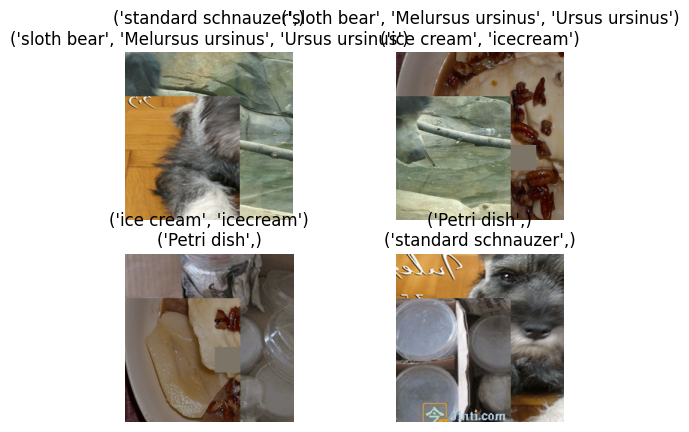

In [78]:
import matplotlib.pyplot as plt
import torch

# try using cutmixup
cutmixup = CutMixup(cutmix_alpha=merged_cfg.augmentation.cutmix.alpha, 
                    mixup_alpha=merged_cfg.augmentation.mixup.alpha,
                    num_classes=merged_cfg.data.num_classes)
# load a batch
img, target = next(iter(train_loader))
img, target = cutmixup(img, target)

# let's rescale the images to pre-imagenet standard
img = (img * torch.tensor(IMAGENET_DEFAULT_STD)[None, :, None, None] + torch.tensor(IMAGENET_DEFAULT_MEAN)[None, :, None, None])

# we need to convert labels back to text
# first get the index of the max logit
label_idx = torch.topk(target, k=2, dim=-1).indices
# then get the top 2 label from the index
labels = []
for i in label_idx:
    labels.append([train_loader.dataset.classes[i[0].item()], train_loader.dataset.classes[i[1].item()]])
# plot the images without borders and labels
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img[0].permute(1, 2, 0).numpy())
axs[0, 0].set_title(f"{labels[0][0]}\n{labels[0][1]}")
axs[0, 1].imshow(img[1].permute(1, 2, 0).numpy())
axs[0, 1].set_title(f"{labels[1][0]}\n{labels[1][1]}")
axs[1, 0].imshow(img[2].permute(1, 2, 0).numpy())
axs[1, 0].set_title(f"{labels[2][0]}\n{labels[2][1]}")
axs[1, 1].imshow(img[3].permute(1, 2, 0).numpy())
axs[1, 1].set_title(f"{labels[3][0]}\n{labels[3][1]}")
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
plt.show()